In [1]:
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
from time import time
import pandas as pd
import numpy as np
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

### Увод
Прогнозирането на електроенергийното потребление е критично за оптималното управление на енергийни ресурси, планирането на електроразпределителните мрежи и подобряването на ефективността на индустриалните предприятия. В тази курсова работа се изследват няколко различни метода за прогнозиране на потреблението: *Histogram-based Gradient Boosting Regression*, *Random Forest*, *Adaptive Boosting Regression*, *Support Vector Regression* и *Category Boosting Regression*, като се анализира тяхната точност върху два различни набора от данни. Първо, петте ML алгоритъма ще бъдат тествани и от тях ще бъдат избрани трите най-добре представили се. Те ще бъдат тренирани и накрая ще ги съпоставим, за да разберем каква е тяхната успеваемост спрямо класическите изчеслителни методи. Отделно, целият процес ще го повторим за 2 различни набора данни, за да установим, какво е значението от различното извличане на данни. Целта е да се установи кой от тези методи предоставя най-добра прогнозна способност при различни времеви резолюции и индустриални среди.

# Energy predictor
### Интелигентни методи за прогнозиране на електроенергийното потребление

### Подходи за прогнозиране на електроенергийното потребление
В индустриалния сектор прогнозите за електроенергийно потребление се основават на комбинация от традиционни статистически методи и модерни машинно-обучителни алгоритми. Компании като Siemens, General Electric и Schneider Electric интегрират тези технологии в своите интелигентни мрежови решения, за да подобрят точността на прогнозите и ефективността на разпределението.

Сред използваните алгоритми, *Random Forest* и *Gradient Boosting Regressor* представляват ансамблови методи, които използват множество дървета на решения, за да подобрят точността. *Histogram-based Gradient Boosting Regressor* е оптимизирана версия на *Gradient Boosting*, която работи по-ефективно с големи набори от данни. *Adaptive Boosting Regression* се основава на комбинация от слаби обучаващи модели, които постепенно подобряват точността, докато *Category Boosting* е специално разработен за обработка на категорийни данни и сложни нелинейни зависимости. *Support Vector Regression (SVR)* е мощен метод, който използва хиперплоскости за намиране на най-добрите регресионни граници и се справя добре с малки и средно големи набори от данни.

Всеки от тези методи има своите предимства и недостатъци. *Random Forest* предлага стабилност и е устойчив на преобучение, но може да бъде по-бавен при обработка на големи обеми данни. *Gradient Boosting* и неговите варианти често постигат висока точност, но са чувствителни към настройките на параметрите и изискват повече изчислителни ресурси. *Adaptive Boosting* може да подобри резултатите на базовите модели, но има тенденция да бъде по-податлив на шум в данните. *Category Boosting* е ефективен при обработка на данни с различни видове признаци, но може да бъде по-сложен за настройка. *Support Vector Regression* е подходящ за данни с висока дименсионалност, но може да бъде изчислително интензивен при големи набори от данни.

### Проектиране
Използваме Jupyter Notebook за разработка на проекта – поставяме различни хипотези, тестваме различни алгоритми, мерим резултата и документираме експериментите. Най-добрият модел се експортира в .sav файл, който може да се използва от софтуерните инженери, за да създадат потребителски интерфейс и цялостно приложение, което да се използва от крайните потребители.

За целите на анализа се използват 2 различни набора данни:
* Потребление на електричество от компания, работеща в металургическия сектор от [Kaggle](https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption). Данните са за цялата календарна 2018 година, като наблюденията за потреблението са на 15 минутни интервали - 35038 реда.
* Потребление от компания, занимаваща се с производство на везни и кантари, базирана в Силистра. Данните са събрани от терен за 6 месечен период, наблюденията са на 5 минутни интервали - 53000 реда.

Върху двата набора от данни се прилага stratified split разпределение 80/20 за обучение и тестване. Избраните характеристики са:
* `energy_consumption` в kWh за времевия интервал
* `time` точно време и час на отчитане на метриката
* `day_of_week` ден от седмицата в интервала 0-6 (понеделник - неделя)
* `month` месец от годината 0-11 (януари - декември)
* `is_weekend` булева характеристика, дали е работен ден



### Реализация, тестване и експерименти
#### Използвани технологии, платформи и библиотеки
За реализацията на прогнозните модели се използват следните технологии:
* Python като програмен език
* Scikit-learn за Random Forest и Gradient Boosting Regression, Adaptive Boosting и Support Vector Regression
* CatBoost за Category Boosting
* Pandas и NumPy за обработка на данните
* Matplotlib и Seaborn за визуализация на резултатите

#### Реализация
Експрерименталният процес включва следните стъпки:
* Предварителна обработка на данните – почистване, трансформиране и нормализиране
* Разделяне на данните на 2 части - обучаващи и тестови
* Обучение на моделите – настройване на параметри чрез `GridSearch` за оптимална производителност
* Тестване на моделите върху тестовия набор от данни
* Запазване на обучените модели като файлове за бъдещи корекции
* Оценка на моделите – сравнение чрез метриките Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Square Error (RMSE), Coefficient of Determination (R^2).
* Анализ на резултатите – визуализация на предсказаните спрямо реалните стойности.

### Дефиниране на помощни функции
Започваме с дефиниране на някои функции, които ще бъдат често използвани. 
Ще дефинираме помощна функция **fit_model**, която ще извърши grid search върху нашите модели и ще върне речник със следната информация: 
 - **model** - съдържа името на алгоритъма 
- **number_features_training** - съдържа броя на характеристиките в текущия модел 
- **best_estimator** - съдържа най-добрия модел от проведения grid search
- **best_params** - съдържа най-добрите хиперпараметри, които дават най-високите метрики (в нашия случай "точност")
- **best_score** - съдържа най-високият резултат за точност
- **time_sec** - съдържа времето за изпълнение на grid_search 


In [4]:
def fit_model(model, parameters_grid, k_fold, X_train, y_train):
    t0 = time()
    grid_search = GridSearchCV(model, parameters_grid, n_jobs=1, scoring='r2', cv=k_fold)
    grid_search.fit(X_train, y_train)
    t1 = time() - t0

    return {"model": model.__class__.__name__,
            "number_of_observations_training": X_train.shape[0],
            "number_features_training": X_train.shape[1],
            "best_estimator": grid_search.best_estimator_,
            "best_params": grid_search.best_params_,
            "best_score": grid_search.best_score_,
            "time_sec": t1}

Освен това, имаме и няколко функции, които се занимават с форматирането на входните данни, както и с подравняването за тестовете на двата набора от данни.

In [5]:
def set_lags_15min(df):
    df['lag_1'] = df['energy_consumption'].shift(1)
    df['lag_1h'] = df['energy_consumption'].shift(4)
    df['lag_1d'] = df['energy_consumption'].shift(96)
    df['lag_7d'] = df['energy_consumption'].shift(672)
    df['lag_1m'] = df['energy_consumption'].shift(2880)  # 30 days * 24 hours * 4 intervals/hr = 2880

In [6]:
def set_lags_5min(df):
    df['lag_1'] = df['energy_consumption'].shift(1)
    df['lag_1h'] = df['energy_consumption'].shift(12)
    df['lag_1d'] = df['energy_consumption'].shift(288)
    df['lag_7d'] = df['energy_consumption'].shift(2016)
    df['lag_1m'] = df['energy_consumption'].shift(8640) # 30 days * 24 hours * 12 intervals/hr = 8640

In [7]:
def set_time(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    if 'WeekStatus' in df.columns:
        df['is_weekend'] = df['WeekStatus'].map({'Weekday': 0, 'Weekend': 1})
    else:
        df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

## Зареждане и анализиране на данните

In [8]:
year_df = pd.read_csv(
    'year_data.csv',
    parse_dates=['date'],
    date_format="%d/%m/%Y %H:%M"
)

In [9]:
half_df = pd.read_csv(
    'half_year_data.csv',
    parse_dates=['date'],
    date_format="%Y/%m/%d %H:%M:%S"
)

In [10]:
year_df.set_index('date', inplace=True)
half_df.set_index('date', inplace=True)

In [11]:
year_df = year_df.dropna(subset=['energy_consumption'])
half_df = half_df.dropna(subset=['energy_consumption'])

In [12]:
set_time(year_df)
set_time(half_df)
set_lags_15min(year_df)
set_lags_5min(half_df)

In [13]:
columns_to_keep = ['energy_consumption', 'hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_1h', 'lag_1d', 'lag_7d', 'lag_1m']

year_df = year_df[columns_to_keep]
half_df = half_df[columns_to_keep]

year_df.dropna(inplace=True)
half_df.dropna(inplace=True)

In [14]:
year_df.tail(5)

,energy_consumption,hour,day_of_week,month,is_weekend,lag_1,lag_1h,lag_1d,lag_7d,lag_1m
date,,,,,,,,,,
2018-12-31 23:00:00,3.85,23,0,12,0,3.82,3.42,3.02,3.85,3.42
2018-12-31 23:15:00,3.74,23,0,12,0,3.85,3.24,2.95,3.85,3.28
2018-12-31 23:30:00,3.78,23,0,12,0,3.74,3.67,2.99,3.82,3.38
2018-12-31 23:45:00,3.78,23,0,12,0,3.78,3.82,2.92,3.85,3.31
2018-12-31 00:00:00,3.67,0,0,12,0,3.78,3.85,3.10,3.78,3.35


In [15]:
half_df.tail(5)

,energy_consumption,hour,day_of_week,month,is_weekend,lag_1,lag_1h,lag_1d,lag_7d,lag_1m
date,,,,,,,,,,
2025-01-15 19:40:00,4.82,19,2,1,0,4.79,6.18,10.81,5.69,3.77
2025-01-15 19:45:00,2.31,19,2,1,0,4.82,5.37,11.46,3.04,4.61
2025-01-15 19:50:00,3.50,19,2,1,0,2.31,5.13,10.47,3.04,4.33
2025-01-15 19:55:00,4.33,19,2,1,0,3.50,4.38,10.30,3.03,4.31
2025-01-15 20:00:00,4.41,20,2,1,0,4.33,6.95,8.87,4.98,4.27


In [16]:
year_df.describe()

,energy_consumption,hour,day_of_week,month,is_weekend,lag_1,lag_1h,lag_1d,lag_7d,lag_1m
count,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000,32160.000000
mean,26.105095,11.500000,3.005970,7.020896,0.286567,26.108028,26.115840,26.257272,26.810880,28.016340
std,32.293016,6.922294,2.000022,3.158007,0.452165,32.295261,32.300208,32.370944,32.663332,33.867196
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000,5.750000,1.000000,4.000000,0.000000,3.170000,3.170000,3.170000,3.170000,3.170000
50%,4.180000,11.500000,3.000000,7.000000,0.000000,4.180000,4.180000,4.180000,4.320000,4.610000
75%,49.977500,17.250000,5.000000,10.000000,1.000000,50.000000,50.000000,50.290000,50.760000,51.840000
max,157.180000,23.000000,6.000000,12.000000,1.000000,157.180000,157.180000,157.180000,157.180000,157.180000


In [17]:
half_df.describe()

,energy_consumption,hour,day_of_week,month,is_weekend,lag_1,lag_1h,lag_1d,lag_7d,lag_1m
count,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000,43479.000000
mean,13.838550,11.500034,3.008855,9.309161,0.291359,13.838623,13.838433,13.786793,13.630228,14.106281
std,19.259735,6.940150,2.007298,3.018650,0.454394,19.259706,19.259793,19.194485,18.952430,19.033400
min,-3.740000,0.000000,0.000000,1.000000,0.000000,-3.740000,-3.740000,-3.740000,-3.740000,-0.020000
25%,2.670000,5.000000,1.000000,9.000000,0.000000,2.670000,2.670000,2.670000,2.650000,2.650000
50%,4.210000,11.000000,3.000000,10.000000,0.000000,4.210000,4.210000,4.170000,4.060000,3.860000
75%,13.110000,18.000000,5.000000,11.000000,1.000000,13.110000,13.110000,13.225000,13.970000,20.815000
max,110.600000,23.000000,6.000000,12.000000,1.000000,110.600000,110.600000,110.600000,110.600000,110.600000


### Разделяме целия dataset на характерситки(features) и етикети(labels)

In [18]:
feature_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_1h','lag_7d', 'lag_1d', 'lag_1m']
year_feats = year_df[feature_cols]
half_feats = half_df[feature_cols]

year_labels = year_df['energy_consumption']
half_labels = half_df['energy_consumption']

### Метрики за измерване на производителността на модела
Въпреки че има други начини за измерване на производителността на модела (precision, recall, F1 Score, ROC Curve и др.), ще запазим нещата прости и ще използваме r2 като наша метрика. След това ще покажем confusion matrix за реални и предсказани етикети и classification report.

### Разделяме данните на обучаващи и тестови
Разделяме набора от характеристики, на 80% обучиаващи и 20% тестови. Разделяме характеристиките едновременно с етикетите. Важно е да отбележим, че запазваме последователността на данните, за да не загубим информация за потреблението в хронологичен ред.

In [19]:
def split(df, X, y):
    split_index = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    return X_train, X_test, y_train, y_test

In [20]:
year_feats_train, year_feats_test, year_labels_train, year_labels_test = split(year_df, year_feats, year_labels)
half_feats_train, half_feats_test, half_labels_train, half_labels_test = split(half_df, half_feats, half_labels)

In [21]:
print("Shape of year training features: "+str(year_feats_train.shape))
print("Shape of year testing features: "+str(year_feats_test.shape))
print("-------------------------------------------")
print("Shape of year training labels: "+str(year_labels_train.shape))
print("Shape of year testing labels: "+str(year_labels_test.shape))

Shape of year training features: (25728, 9)
Shape of year testing features: (6432, 9)
-------------------------------------------
Shape of year training labels: (25728,)
Shape of year testing labels: (6432,)


In [22]:
print("Shape of half year training features: "+str(half_feats_train.shape))
print("Shape of half year testing features: "+str(half_feats_test.shape))
print("-------------------------------------------")
print("Shape of half year training labels: "+str(half_labels_train.shape))
print("Shape of half year testing labels: "+str(half_labels_test.shape))

Shape of half year training features: (34783, 9)
Shape of half year testing features: (8696, 9)
-------------------------------------------
Shape of half year training labels: (34783,)
Shape of half year testing labels: (8696,)


Обучаващите и тестовите характеристики и етикети изглеждат, че имат правилната форма.

Ще запазим текущият тестов набор от данни, така че да можем да го запазим точно същия за бъдеща употреба, когато тестваме резултатите за запазените модели, които са били обучени с текущото разделяне на обучаващите данни.

In [23]:
test_set = {"X":year_feats_test, "y":year_labels_test}
dump(test_set,"year_test_set-BACKUP.sav")

['year_test_set-BACKUP.sav']

In [24]:
test_set = {"X":half_feats_test, "y":half_labels_test}
dump(test_set,"half_test_set-BACKUP.sav")

['half_test_set-BACKUP.sav']

In [25]:
# Разкоментирай това, ако искате да използвате оригиналния тестов набор от данни 
# test_set_loaded = load('year_test_set-BACKUP.sav')
# year_feats_test = test_set_loaded["X"]
# year_labels_test = test_set_loaded["y"]

## Сравнение на ML алгоритмите за данните с 5 минутен интервал

Ще тренираме и тестваме моделите на двата различни набора от данни, поради разликата в методите им на отчитане на енергия. Това може да означава, че по - общият модел (15 минутен интервал) е по - ефективен, тъй като информацията в него е по - консолидирана с намалена дисперсия. Това е специфика на сектора, в който сравняваме тези модели, защото електропотреблението може да варира доста в рамките на минути, поради различните режими на работа на електроуредите и поведението на хората. Например използването на микровълновъва фурна в 12 часа на обяд би се отразила като голяма флуктоация, но е само за няколко минути и бихме могли да я изключим в общата "картина" за потребление на индустриално потребление.

### Избиране на алгоритми
Използвайки cross validation с 5 фолда върху обучаващия набор с 'r2' като метрика, ще изберем три от най-добрите алгоритъма. Ще ги стартираме с техните настройки по подразбиране. Петте кандидата са:
* Gradient Boosting Regression
* AdaBoost Regression
* Random Forrest
* Support Vector Regression
* Category Boosting Regression



In [26]:
k_fold = KFold(n_splits = 5)

In [74]:
results = []
names = []
scoring = 'r2'
algorithms = []
algorithms.append(("HGBR", HistGradientBoostingRegressor(verbose=0)))
algorithms.append(("AdaBoost", AdaBoostRegressor()))
algorithms.append(("RandomForest", RandomForestRegressor(verbose=0)))
algorithms.append(("SVR", SVR(verbose=0)))
algorithms.append(("CatBoostRegressor", CatBoostRegressor(verbose=0)))
for name, algorithm in algorithms:
    t0=time()   
    cv_results = cross_val_score(algorithm, half_feats_train, half_labels_train, cv= k_fold, scoring = scoring)
    t1 = time() - t0
    results.append(cv_results)
    names.append(name)
    print("{0}: mean r2 {1:.3%} - standard deviation {2:.4} - time {3:n}".format(name, cv_results.mean(), cv_results.std(), t1))

HGBR: mean r2 90.850% - standard deviation 0.00806 - time 0.825964
AdaBoost: mean r2 87.538% - standard deviation 0.01588 - time 3.13016
RandomForest: mean r2 90.350% - standard deviation 0.007167 - time 60.32
SVR: mean r2 90.239% - standard deviation 0.007325 - time 72.3117
CatBoostRegressor: mean r2 90.513% - standard deviation 0.008161 - time 5.92087


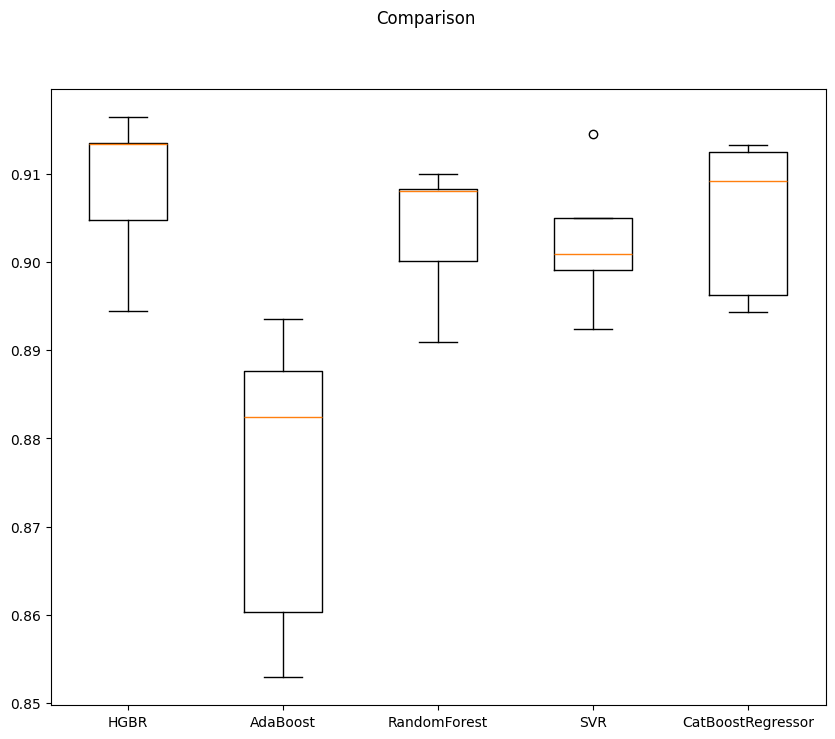

In [75]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Както се вижта ясно от графиката, трите най - добри алгоритъма са Histogram Gradient Boosting Regression, Category Boosting Regression и Random Forest. Въпреки че Random Forest е значително по - бавен, той по - добър от AdaBoost и SVR, поради което се спираме на него като 3ти алгоритъм за по - подробен анализ.

In [33]:
refined_models = {} # list for saving the optimized models

### Random Forest

In [40]:
model = RandomForestRegressor()
parameters_grid = [{
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 5, 10],
}]
model_fit = fit_model(model, parameters_grid, k_fold, half_feats_train, half_labels_train)

In [41]:
model_fit

{'model': 'RandomForestRegressor',
 'number_of_observations_training': 34783,
 'number_features_training': 9,
 'best_estimator': RandomForestRegressor(max_depth=5),
 'best_params': {'max_depth': 5, 'n_estimators': 100},
 'best_score': 0.9104016599630558,
 'time_sec': 282.4987325668335}

In [116]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 91.029%


Оценката не е значително по - висока спрямо първоначалния подбор. Следващата стъпка е да тестваме модела спрямо тестовите данни.

In [34]:
# Load saved model
best_model = joblib.load("half_rf.sav")

In [35]:
#best_model = model_fit['best_estimator']
refined_models['half_rf'] = best_model
score = best_model.score(half_feats_test, half_labels_test)
print("Test score {0:.3%}".format(score))

Test score 92.403%


Тестовата оценка е добра, така че запазваме данните за модела, за да избегнем генерирането му наново при следващи тестове.

In [30]:
model_fit['best_score'] = score

NameError: name 'model_fit' is not defined

Нека покажем разликата в резултатите между тестовите прогнози и реалните стойности

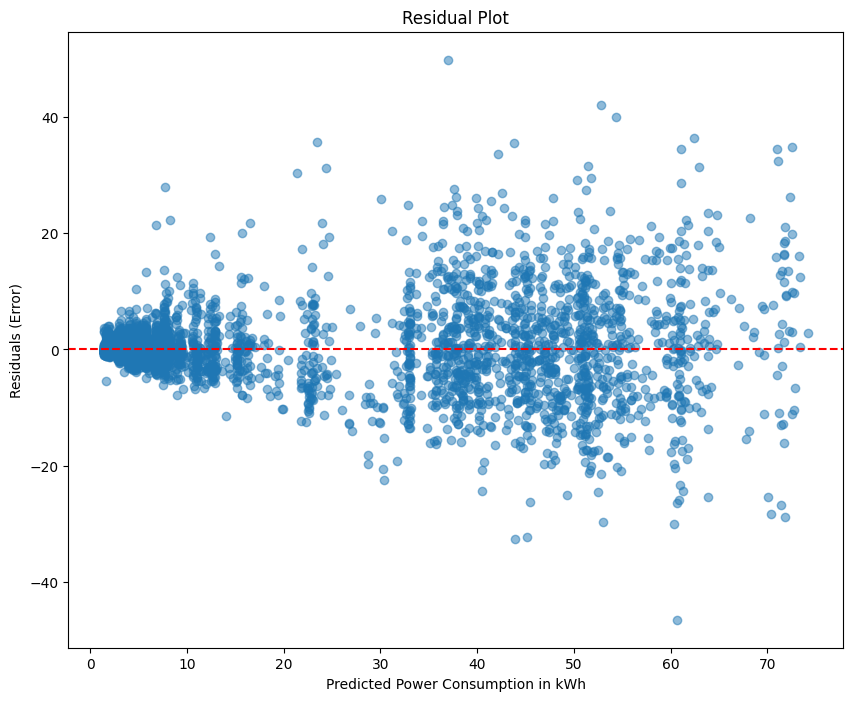

In [46]:
pred = best_model.predict(half_feats_test)
residuals = half_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [47]:
mae = mean_absolute_error(half_labels_test, pred)
rmse = mean_squared_error(half_labels_test, pred)  # Square root of MSE
r2 = r2_score(half_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 2.1928
Root Mean Square Error (RMSE): 21.9146
R² Score: 0.9240


In [48]:
joblib.dump(best_model, "half_rf.sav")

['half_rf.sav']

### Category Boosting Regression

In [54]:
model = CatBoostRegressor(verbose=0)
parameters_grid = [{
    "iterations": [200, 500, 1000],  # Number of boosting iterations
    "learning_rate": [0.01, 0.05, 0.1],  # Learning rate (smaller = better generalization)
    "depth": [4, 6, 8, 10],  # Tree depth (controls model complexity)
    "l2_leaf_reg": [1, 3, 5, 7],  # L2 regularization (prevents overfitting)
}]
model_fit = fit_model(model, parameters_grid, k_fold, half_feats_train, half_labels_train)

In [55]:
model_fit

{'model': 'CatBoostRegressor',
 'number_of_observations_training': 34783,
 'number_features_training': 9,
 'best_estimator': <catboost.core.CatBoostRegressor at 0x7dda43902ae0>,
 'best_params': {'depth': 6,
  'iterations': 1000,
  'l2_leaf_reg': 7,
  'learning_rate': 0.01},
 'best_score': 0.9117558460590299,
 'time_sec': 1038.05260014534}

In [56]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 91.176%


Оценката не е значително по - висока спрямо първоначалния подбор. Следващата стъпка е да тестваме модела спрямо тестовите данни.

In [36]:
# Load saved model
best_model = joblib.load("half_cbr.sav")

In [37]:
#best_model = model_fit['best_estimator']
refined_models['half_cbr'] = best_model
score = best_model.score(half_feats_test, half_labels_test)
print("Test score {0:.3%}".format(score))

Test score 92.046%


Забелязваме, че тестовата оценка е по - ниска от тази на Random Forest, въпреки по - добрия резултат на Category Boosting Regression при останалите сравнанения. Това означва, че Random Forest се справя значително по - добре с обобщаването на данните.

In [59]:
model_fit['best_score'] = score

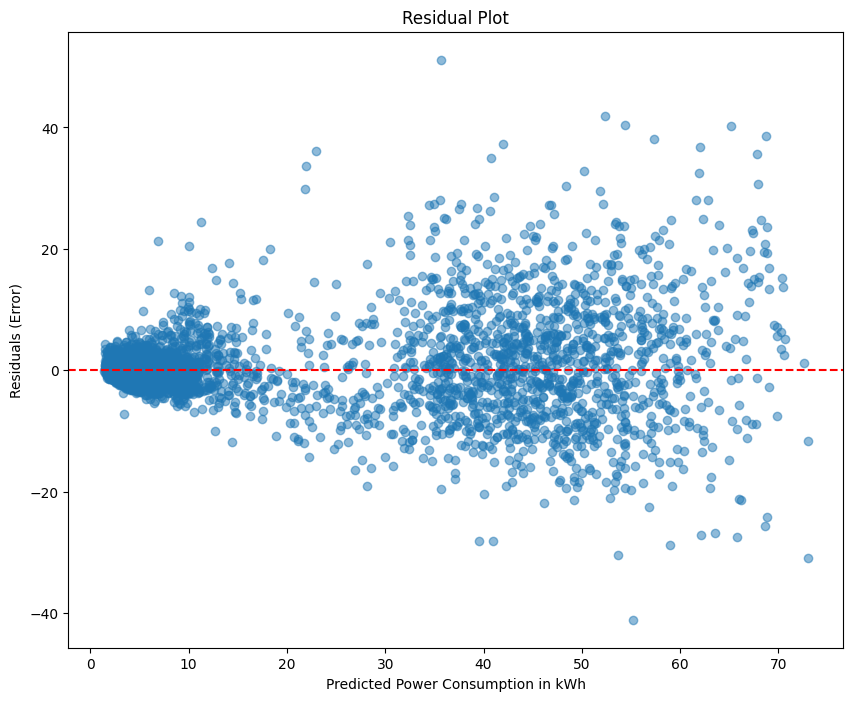

In [64]:
pred = best_model.predict(half_feats_test)
residuals = half_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [65]:
mae = mean_absolute_error(half_labels_test, pred)
rmse = mean_squared_error(half_labels_test, pred)  # Square root of MSE
r2 = r2_score(half_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 2.4046
Root Mean Square Error (RMSE): 22.9440
R² Score: 0.9205


In [66]:
joblib.dump(best_model, "half_cbr.sav")

['half_cbr.sav']

### Histogram Gragient Boosting Regression
Използваме **HistGradientBoostingRegressor (HGBR)** вместо **GradientBoostingRegressor (GBR)**, защото HGBR е оптимизиран за **големи набори от данни** и е значително по-бърз. HGBR използва **дискретизация на данните в хистограми**, което намалява сложността и паметната консумация, докато GBR изгражда дървета, които обработват всяка стойност поотделно, което е по-бавно. **Предимствата на HGBR** включват **по-добра мащабируемост, вградена поддръжка за ранно спиране и по-добра работа с числови данни**. Въпреки това, **недостатъкът на HGBR** е, че не поддържа **категориални променливи директно** (за разлика от CatBoost) и понякога може да загуби детайлност при по-малки набори от данни. От друга страна, **GBR е по-гъвкав**, особено за **по-малки или по-шумни данни**, но страда от **по-бавно обучение и по-висока паметна консумация**. Конкретно в нашия случай, скоростта при трениране на моделите е основната разлика, заради която ще се спрем на HGBR.

In [89]:
model = HistGradientBoostingRegressor(verbose=0)
parameters_grid = [{
    "learning_rate": [0.01, 0.05, 0.1],  # Step size at each iteration
    "max_iter": [200, 500, 1000],  # Number of boosting iterations
    "max_depth": [3, 5, 7, 10],  # Depth of each tree
    "max_leaf_nodes": [10, 20, 31, 50],  # Max number of leaf nodes per tree
    "early_stopping": [True],  # Stop training if validation score stops improving
}]
model_fit = fit_model(model, parameters_grid, k_fold, half_feats_train, half_labels_train)

In [90]:
model_fit

{'model': 'HistGradientBoostingRegressor',
 'number_of_observations_training': 34783,
 'number_features_training': 9,
 'best_estimator': HistGradientBoostingRegressor(early_stopping=True, learning_rate=0.05,
                               max_depth=3, max_iter=1000, max_leaf_nodes=10),
 'best_params': {'early_stopping': True,
  'learning_rate': 0.05,
  'max_depth': 3,
  'max_iter': 1000,
  'max_leaf_nodes': 10},
 'best_score': 0.9119880394850179,
 'time_sec': 237.53853964805603}

In [91]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 91.199%


Оценката не е значително по - висока спрямо първоначалния подбор. Осезаема обаче е разликата във времето за трениране на този модел. Тук имаме само 237 секунди, за разлика от 1038 секунди при **CatBoost**, където наблюдаваме почти идентичен резултат

In [38]:
# Load saved model
best_model = joblib.load("half_hgbr.sav")

In [39]:
#best_model = model_fit['best_estimator']
refined_models['half_hgbr'] = best_model
score = best_model.score(half_feats_test, half_labels_test)
print("Test score {0:.3%}".format(score))

Test score 92.224%


Тук оценката е малко по - ниска, спрямо тази на **Random Forest**, въпреки че и двете имат сходно време за трениране - HSGBR e по - бърз с **~23 секунди**

In [94]:
model_fit['best_score'] = score

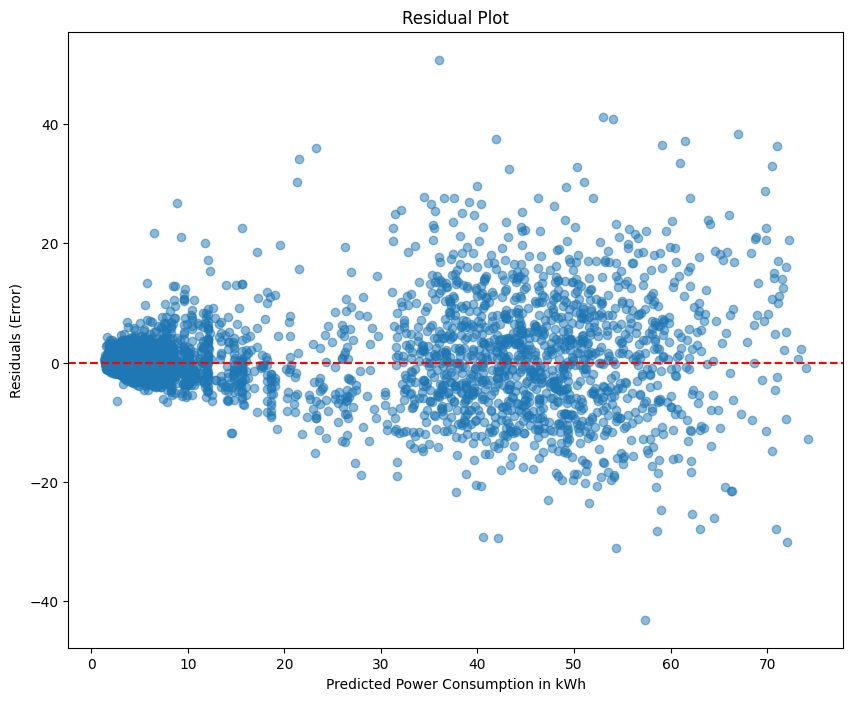

In [95]:
pred = best_model.predict(half_feats_test)
residuals = half_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [96]:
mae = mean_absolute_error(half_labels_test, pred)
rmse = mean_squared_error(half_labels_test, pred)  # Square root of MSE
r2 = r2_score(half_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 2.2943
Root Mean Square Error (RMSE): 22.4319
R² Score: 0.9222


In [97]:
joblib.dump(best_model, "half_hgbr.sav")

['half_hgbr.sav']

## Сравнение на ML алгоритмите за данните с 15 минутен интервал

Нека направим същите сравнения и на втората група от данни. Това ще ни даде доста по - добро разбиране, как работят тези модели и какъв подбор на данни е нужно да направим за оптимални резултати

### Избор на алгоритми

In [99]:
results = []
names = []
scoring = 'r2'
algorithms = []
algorithms.append(("HGBR", HistGradientBoostingRegressor(verbose=0)))
algorithms.append(("AdaBoost", AdaBoostRegressor()))
algorithms.append(("RandomForest", RandomForestRegressor(verbose=0)))
algorithms.append(("SVR", SVR(verbose=0)))
algorithms.append(("CatBoostRegressor", CatBoostRegressor(verbose=0)))
for name, algorithm in algorithms:
    t0=time()   
    cv_results = cross_val_score(algorithm, year_feats_train, year_labels_train, cv= k_fold, scoring = scoring)
    t1 = time() - t0
    results.append(cv_results)
    names.append(name)
    print("{0}: mean r2 {1:.3%} - standard deviation {2:.4} - time {3:n}".format(name, cv_results.mean(), cv_results.std(), t1))

HGBR: mean r2 88.878% - standard deviation 0.02141 - time 0.868416
AdaBoost: mean r2 81.995% - standard deviation 0.03007 - time 2.65092
RandomForest: mean r2 88.191% - standard deviation 0.02228 - time 37.6435
SVR: mean r2 85.252% - standard deviation 0.01347 - time 38.6259
CatBoostRegressor: mean r2 88.283% - standard deviation 0.02581 - time 5.25396


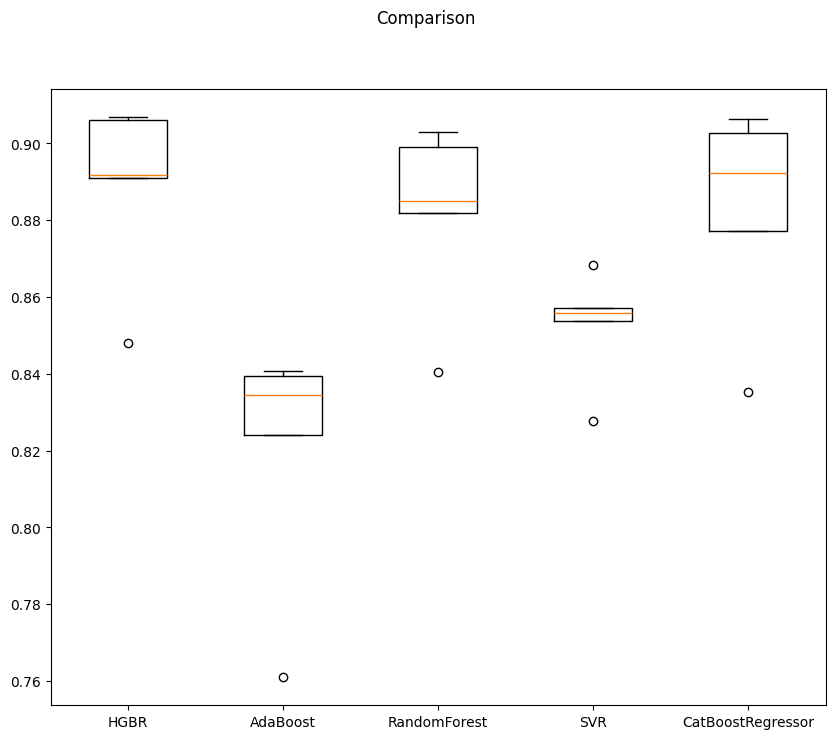

In [100]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

При по-широкия диапазон от информация, виждаме запазване на последователността от алгоритми, като основната разлика е че точността им е с около 2 пункта по-ниска.

## Random Forest

In [101]:
model = RandomForestRegressor()
parameters_grid = [{
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 5, 10],
}]
model_fit = fit_model(model, parameters_grid, k_fold, year_feats_train, year_labels_train)

In [106]:
model_fit

{'model': 'RandomForestRegressor',
 'number_of_observations_training': 25728,
 'number_features_training': 9,
 'best_estimator': RandomForestRegressor(max_depth=10, n_estimators=300),
 'best_params': {'max_depth': 10, 'n_estimators': 300},
 'best_score': 0.8852067633262906,
 'time_sec': 188.7670624256134}

In [104]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 88.521%


Оценката не е значително по - висока спрямо първоначалния подбор. Следващата стъпка е да тестваме модела спрямо тестовите данни.

In [40]:
# Load saved model
best_model = joblib.load("year_rf.sav")

In [41]:
#best_model = model_fit['best_estimator']
refined_models['year_rf'] = best_model
score = best_model.score(year_feats_test, year_labels_test)
print("Test score {0:.3%}".format(score))

Test score 91.186%


Тук виждаме по-лоша тестова оценка спрямо тренировърната информация и спрямо същия алгоритъм за 5 минутни интервали. Въпреки това, тя е по-добра спрямо резултата на тренировъчната информация

In [125]:
model_fit['best_score'] = score

Нека покажем разликата в резултатите между тестовите прогнози и реалните стойности

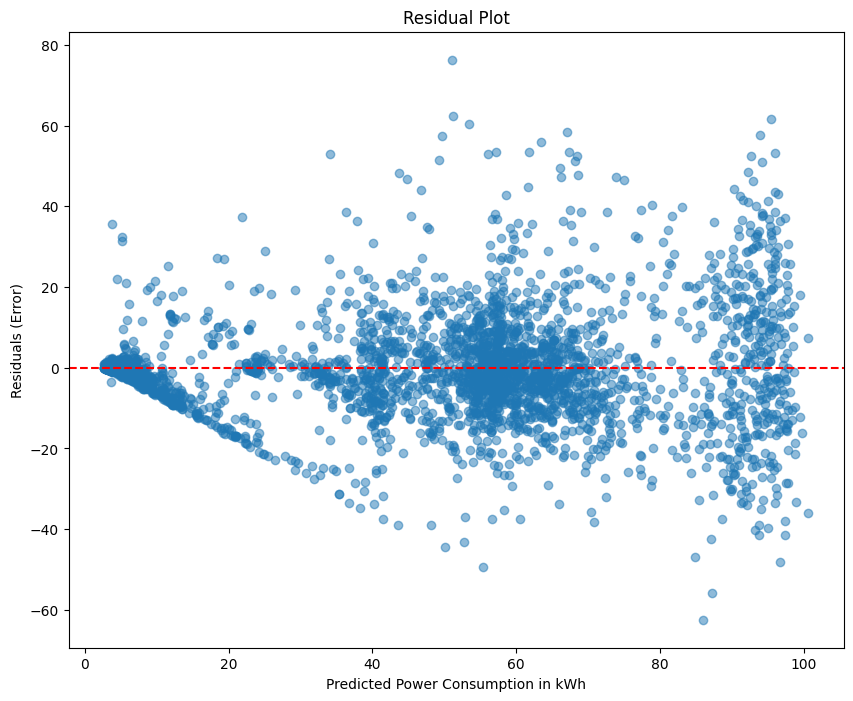

In [127]:
pred = best_model.predict(year_feats_test)
residuals = year_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [128]:
mae = mean_absolute_error(year_labels_test, pred)
rmse = mean_squared_error(year_labels_test, pred)  # Square root of MSE
r2 = r2_score(year_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 4.5163
Root Mean Square Error (RMSE): 87.1134
R² Score: 0.9119


In [129]:
joblib.dump(best_model, "year_rf.sav")

['year_rf.sav']

Можем да заключим, че при тази конфигурация наблюдаваме доста по-голяма дисперсия на данните, но сумарно алгоритъмът се справя добре.

### Category Boosting Regression

In [130]:
model = CatBoostRegressor(verbose=0)
parameters_grid = [{
    "iterations": [200, 500, 1000],  # Number of boosting iterations
    "learning_rate": [0.01, 0.05, 0.1],  # Learning rate (smaller = better generalization)
    "depth": [4, 6, 8, 10],  # Tree depth (controls model complexity)
    "l2_leaf_reg": [1, 3, 5, 7],  # L2 regularization (prevents overfitting)
}]
model_fit = fit_model(model, parameters_grid, k_fold, year_feats_train, year_labels_train)

In [131]:
model_fit

{'model': 'CatBoostRegressor',
 'number_of_observations_training': 25728,
 'number_features_training': 9,
 'best_estimator': <catboost.core.CatBoostRegressor at 0x7dda4fbe8410>,
 'best_params': {'depth': 6,
  'iterations': 500,
  'l2_leaf_reg': 5,
  'learning_rate': 0.05},
 'best_score': 0.8894011386707568,
 'time_sec': 984.630047082901}

In [133]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 88.940%


Оценката не е значително по - висока спрямо първоначалния подбор. Следващата стъпка е да тестваме модела спрямо тестовите данни.

In [42]:
# Load saved model
best_model = joblib.load("year_cbr.sav")

In [43]:
#best_model = model_fit['best_estimator
refined_models['year_cbr'] = best_model
score = best_model.score(year_feats_test, year_labels_test)
print("Test score {0:.3%}".format(score))

Test score 91.328%


Забелязваме, че тестовата оценка е по - висока от тази на Random Forest, въпреки по - добрия резултат на Category Boosting Regression при останалите сравнанения. Това означва, че CBR се справя значително по - добре с обобщаването на данните, особено в контекста на по малко информация.

In [136]:
model_fit['best_score'] = score

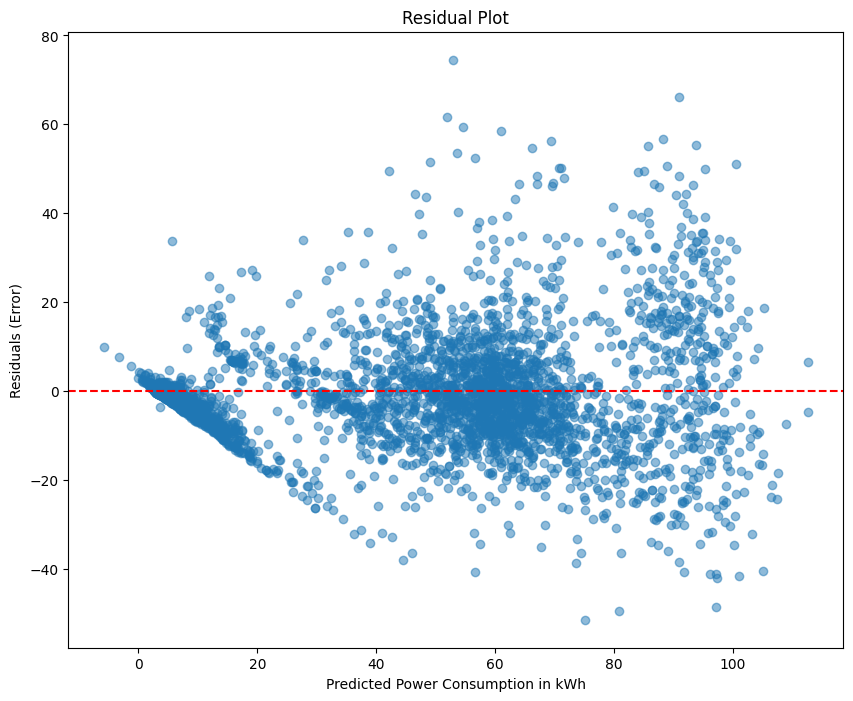

In [137]:
pred = best_model.predict(year_feats_test)
residuals = year_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [138]:
mae = mean_absolute_error(year_labels_test, pred)
rmse = mean_squared_error(year_labels_test, pred)  # Square root of MSE
r2 = r2_score(year_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 4.9202
Root Mean Square Error (RMSE): 85.7071
R² Score: 0.9133


In [139]:
joblib.dump(best_model, "year_cbr.sav")

['year_cbr.sav']

### Histogram Gragient Boosting Regression

In [140]:
model = HistGradientBoostingRegressor(verbose=0)
parameters_grid = [{
    "learning_rate": [0.01, 0.05, 0.1],  # Step size at each iteration
    "max_iter": [200, 500, 1000],  # Number of boosting iterations
    "max_depth": [3, 5, 7, 10],  # Depth of each tree
    "max_leaf_nodes": [10, 20, 31, 50],  # Max number of leaf nodes per tree
    "early_stopping": [True],  # Stop training if validation score stops improving
}]
model_fit = fit_model(model, parameters_grid, k_fold, year_feats_train, year_labels_train)

In [142]:
model_fit

{'model': 'HistGradientBoostingRegressor',
 'number_of_observations_training': 25728,
 'number_features_training': 9,
 'best_estimator': HistGradientBoostingRegressor(early_stopping=True, max_depth=10, max_iter=500,
                               max_leaf_nodes=10),
 'best_params': {'early_stopping': True,
  'learning_rate': 0.1,
  'max_depth': 10,
  'max_iter': 500,
  'max_leaf_nodes': 10},
 'best_score': 0.890122775974881,
 'time_sec': 293.044228553772}

In [143]:
print("R2 score for the selected model is: {0:.3%}".format(model_fit["best_score"]))

R2 score for the selected model is: 89.012%


Оценката не е значително по - висока спрямо първоначалния подбор. **HGBR** обаче запазва първото място, като резултат.

In [44]:
# Load saved model
best_model = joblib.load("year_hgbr.sav")

In [45]:
#best_model = model_fit['best_estimator']
refined_models['year_hgbr'] = best_model
score = best_model.score(year_feats_test, year_labels_test)
print("Test score {0:.3%}".format(score))

Test score 91.327%


Тук оценката е малко по - ниска, спрямо тази на **CBR**, въпреки че и двете имат сходно време за трениране - **HGBR** e по - бърз с **~700 секунди**

In [146]:
model_fit['best_score'] = score

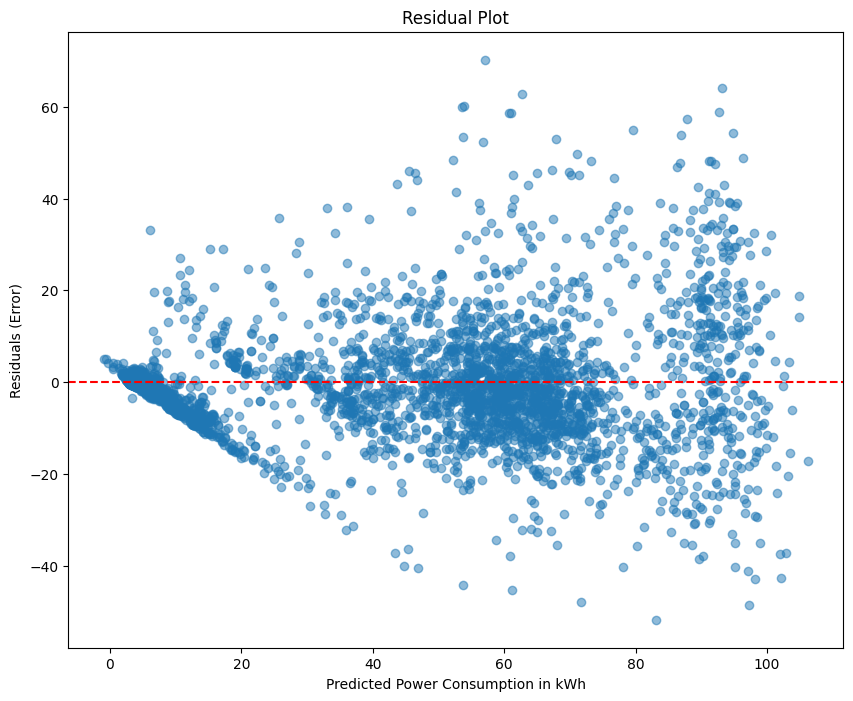

In [147]:
pred = best_model.predict(year_feats_test)
residuals = year_labels_test - pred
plt.figure(figsize=(10, 8))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

In [148]:
mae = mean_absolute_error(year_labels_test, pred)
rmse = mean_squared_error(year_labels_test, pred)  # Square root of MSE
r2 = r2_score(year_labels_test, pred)  # R-squared (coefficient of determination)

print(f"Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Report:
Mean Absolute Error (MAE): 4.6863
Root Mean Square Error (RMSE): 85.7202
R² Score: 0.9133


In [149]:
joblib.dump(best_model, "year_hgbr.sav")

['year_hgbr.sav']

## Анализ на резултатите

След като генерирахме шестте модела е време да разгледаме в детайли финалните резултати. Ще започнем с директно сравнение на моделите по постигната точност на данни за трениране и тестване. 

In [46]:
refined_models

{'half_rf': RandomForestRegressor(max_depth=5),
 'half_cbr': <catboost.core.CatBoostRegressor at 0x77cbc5eed5e0>,
 'half_hgbr': HistGradientBoostingRegressor(early_stopping=True, learning_rate=0.05,
                               max_depth=3, max_iter=1000, max_leaf_nodes=10),
 'year_rf': RandomForestRegressor(max_depth=10, n_estimators=300),
 'year_cbr': <catboost.core.CatBoostRegressor at 0x77cc449a3cb0>,
 'year_hgbr': HistGradientBoostingRegressor(early_stopping=True, max_depth=10, max_iter=500,
                               max_leaf_nodes=10)}

[ 3.54164958  1.5858674   0.13268542 14.39906478  0.71703815  0.15597534]


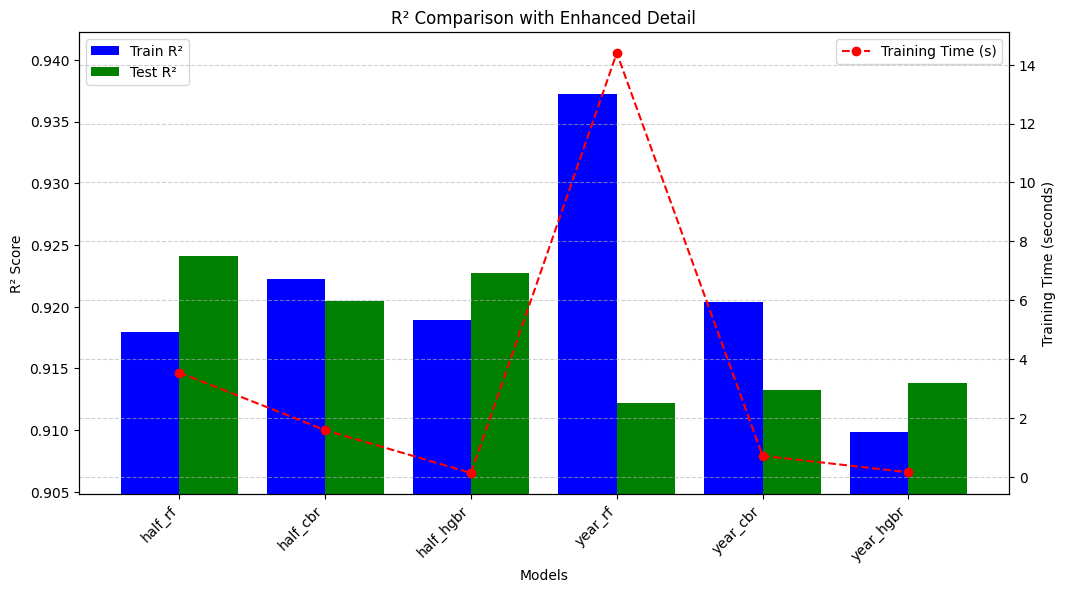

In [47]:
datasets = {
    "half": {
        "X_train": half_feats_train,
        "y_train": half_labels_train,
        "X_test": half_feats_test,
        "y_test": half_labels_test
    },
    "year": {
        "X_train": year_feats_train,
        "y_train": year_labels_train,
        "X_test": year_feats_test,
        "y_test": year_labels_test
    }
}

results = {"train_r2": {}, "test_r2": {}, "train_time": {}}

for name, model in refined_models.items():
    dataset_type = "half" if "half" in name else "year"
    data = datasets[dataset_type]

    start_time = time()
    model.fit(data["X_train"], data["y_train"])
    training_time = time() - start_time

    y_train_pred = model.predict(data["X_train"])
    y_test_pred = model.predict(data["X_test"])

    results["train_r2"][name] = r2_score(data["y_train"], y_train_pred)
    results["test_r2"][name] = r2_score(data["y_test"], y_test_pred)
    results["train_time"][name] = training_time

fig, ax1 = plt.subplots(figsize=(12, 6))

models = list(refined_models.keys())
train_scores = np.array([results["train_r2"][m] for m in models])
test_scores = np.array([results["test_r2"][m] for m in models])
train_times = np.array([results["train_time"][m] for m in models])

x = np.arange(len(models))

# Define min and max R² values for better visibility
min_r2 = min(test_scores.min(), train_scores.min()) - 0.005  # Add small buffer for better contrast
max_r2 = max(test_scores.max(), train_scores.max()) + 0.005

# Bar plot for R² scores with adjusted y-limits
ax1.bar(x - 0.2, train_scores, width=0.4, label="Train R²", align="center", color="blue")
ax1.bar(x + 0.2, test_scores, width=0.4, label="Test R²", align="center", color="green")

ax1.set_ylabel("R² Score")
ax1.set_xlabel("Models")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.legend(loc="upper left")
ax1.set_title("R² Comparison with Enhanced Detail")
ax1.set_ylim(min_r2, max_r2)  # Zooming into the range to show small differences
print(train_times)
# Secondary axis for training time
ax2 = ax1.twinx()
ax2.plot(x, train_times, marker="o", linestyle="--", color="red", label="Training Time (s)")
ax2.set_ylabel("Training Time (seconds)")
ax2.legend(loc="upper right")

plt.grid(axis='y', linestyle='--', alpha=0.6)  # Adding a grid for clarity

plt.show()

Тaзи графикa демонстрира сравнението между **обучителните и тестовите R² стойности**, както и времето за обучение на различните модели.

---

#### **1. Разлика между половин-годишните и едногодишните данни**
- **half модели (6 месеца, 5-минутни интервали):**
  - Данните са с по-висока резолюция, което предполага **повече информация за краткосрочни колебания**.
  - Тези модели имат **по-ниски времена за обучение**, но R² стойностите са относително сходни (около 91.7-92.3%).
  - **Тестовите R² стойности** са почти равни на тренировъчните, което означава **добро обобщение и минимален риск от пренасищане (overfitting)**.

- **year модели (1 година, 15-минутни интервали):**
  - По-дългосрочен набор данни с **по-ниска времева резолюция**, което може да доведе до **по-груби прогнози**.
  - **year_rf (Random Forest)** показва най-висока стойност на R² (94%) за тренировъчни данни, но времето за обучение значително се увеличава.
  - и при трите алгоритъма наблюдаваме значително по видок резултат на тренировъчните данни, спрямо тестовите.
---

#### **2. Важността на обучителното време**
- **half_hgbr и year_hgbr (HistGradientBoostingRegressor):**
  - Те показват **добър баланс между време за обучение и точност**.
  - Особено подходящи за приложения, където скоростта е критична.

- **half_rf (Random Forest):**
  - Висок R², но значително време за обучение, което може да е проблематично за реалновремеви системи.

---

#### **3. Алгоритми и подходящи сценарии**
- **CatBoost (half_cbr, year_cbr):**
  - Изглежда стабилно представяне, но е с малко по-ниски R² стойности в тестовия набор, което предполага леко **подобобщение** на данните.

- **Random Forest (half_rf, year_rf):**
  - По-висока точност, но с компромис във времето за обучение. Подходящ за ситуации, където **производителността не е критична**.

- **HistGradientBoostingRegressor (half_hgbr, year_hgbr):**
  - Впечатляващ компромис между скорост и точност, идеален за реалновремеви системи за управление на енергия.

---
- **За краткосрочни прогнози (напр. за контрол на енергийни системи):** 
  - **half_hgbr** или **half_cbr** са добър избор, поради ниско време за обучение и висока точност.

- **Общи препоръки:**
  - Моделите на **HistGradientBoostingRegressor** предоставят добър компромис между време за обучение и R², което ги прави особено подходящи за повечето приложения.


### Основни разлики между тестовите данни в различните набори от данни

След анализа на самите модели, нека обърнем внимание на разликите в имплементацията модела между двата набори от данни. За целта ще вземем дистрибуцията при *HGBR* за двата вида данни.

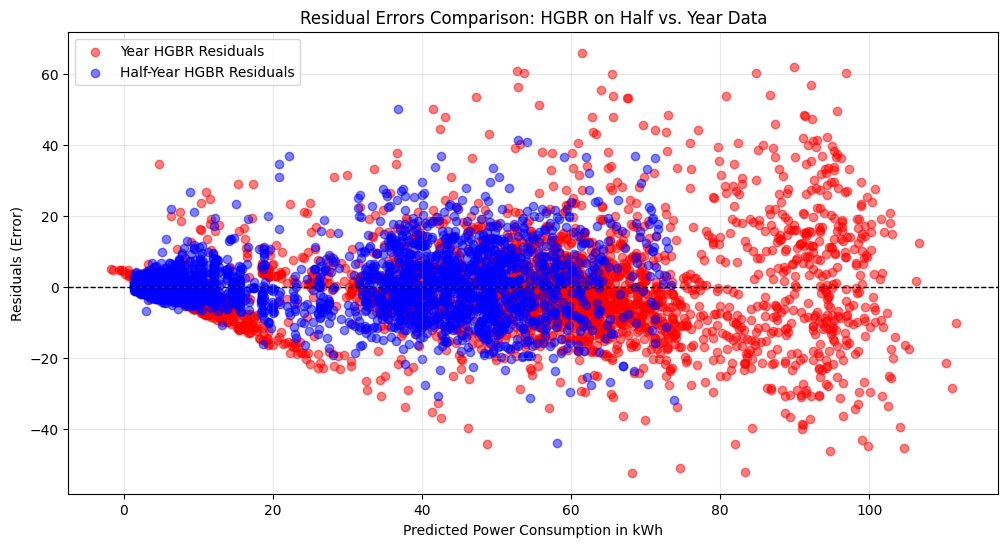

In [65]:
half_hgbr_model = refined_models["half_hgbr"]
year_hgbr_model = refined_models["year_hgbr"]

# Predictions
half_hgbr_preds = half_hgbr_model.predict(datasets["half"]["X_test"])
year_hgbr_preds = year_hgbr_model.predict(datasets["year"]["X_test"])

# Compute residuals
half_hgbr_residuals = datasets["half"]["y_test"] - half_hgbr_preds
year_hgbr_residuals = datasets["year"]["y_test"] - year_hgbr_preds

# Create residual scatter plot
plt.figure(figsize=(12, 6))

plt.scatter(year_hgbr_preds, year_hgbr_residuals, alpha=0.5, color="red", label="Year HGBR Residuals")
plt.scatter(half_hgbr_preds, half_hgbr_residuals, alpha=0.5, color="blue", label="Half-Year HGBR Residuals")


plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Reference line for zero error

plt.xlabel("Predicted Power Consumption in kWh")
plt.ylabel("Residuals (Error)")
plt.title("Residual Errors Comparison: HGBR on Half vs. Year Data")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

Както можем да видим, отклонението на полугодишните данни е доста по-концентрирано около центъра и съответно поради естеството на данните достига по-малки стойности. Забелязваме обаче и една интересна тенденция при годишните данни - грешките се увеличават линейно от 0 до 45 kWh, което подсказва за доста обобщени първоначални данни (underfitting).

### Заключение

Използвахме различни алгоритми за машинно обучение и методи за намаляване на размерността на данните. Въпреки че всички алгоритми се справиха сходно, смятам че *HGBR* за данни с 5 минутни интервали се справи най-добре. Комбинацията от висока точност, изключително малко време за трениране и ниската дисперсия на данните би била перфектна за имплементация в **high availability** системи с много клиенти. 

Използването на 2 различни вида данни показа доста различия в работата на различните алгоритми. Въпреки притесненията налието на данни на всеки 5 минути не доведе до **overfitting**, това обаче може да се промени ако вземем по - извадка данни с по малки стойности. Смятам, че ако се проведе същият експеримент за електропотребление на домакинства, вместо на индустриални предприятия, има потенциал за промяна в избора. Това би се дължало на факта, че в домакинство е много лесно да постигнеш флуктоация в в потреблението за кратък интервал. Това би довело до голяма дисперсия на данните и потенциално, текущите алгоритми не биха се справили токкова добре.

За бъдещи подобрения, би било интересно да се добавят още параметри към първоначалните данни. Наличието на данни за метеорологичните условия, би добавило още информация за разходите за отопление/охлаждане. Също така и параметри, специфични за работния процес в конкретното индустриално предприятие имат потенциал значително да повишат точността на моделите.

### Използвана литература

1. [Energy Consumption Prediction by using Machine Learning Case Study Malaysia](https://www.researchgate.net/publication/347479213_Energy_Consumption_Prediction_by_using_Machine_Learning_for_Smart_Building_Case_Study_in_Malaysia)
2. [Kaggle](https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption)
3. [HistGradientBoostingRegressor](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
4. [RandomForestRegressor](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
5. [AdaBoostRegressor](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)
6. [CatBoostRegressor](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor)
7. [SVR](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html)
8. [KMeans](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)
9. [GridSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html)